In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-dark')
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titlecolor'] = 'w'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelcolor'] = 'w'
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'gray'
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'
plt.rcParams['grid.color'] = 'black'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.autolimit_mode'] = 'data'
plt.rcParams['axes.axisbelow'] = True
from datetime import datetime
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [122]:
START = '2000-01-01'
END = datetime.today().strftime('%Y-%m-%d')
TICKER = 'VNQ'
ticker = yf.download(TICKER,START,END,interval='1mo')['Adj Close']
fed_tickers = ['HOUST','DGS10','VIXCLS']
yahoo_tickers = ['TIO=F','^GSPC']
df_yahoo = yf.download(yahoo_tickers,START,END,interval='1mo')['Adj Close'].dropna()
df_fed = pdr.get_data_fred(fed_tickers,START,END)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  2 of 2 completed


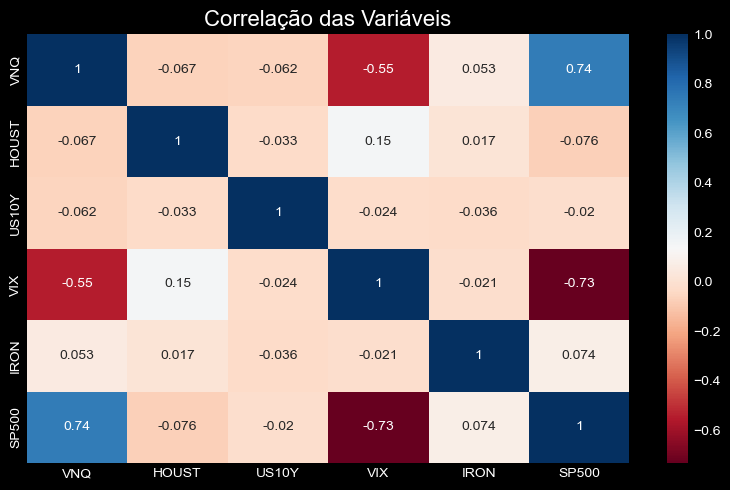

In [124]:
df_model = pd.concat([ticker.resample('ME').last(),
                      df_fed.resample('ME').last(),
                      df_yahoo.resample('ME').last()]
                     ,axis=1,join='inner').dropna()
df_model[yahoo_tickers] = df_model[yahoo_tickers].pct_change()
df_model[TICKER] = df_model[TICKER].pct_change()
df_model[['VIXCLS','HOUST']] = df_model[['VIXCLS','HOUST']].pct_change()
df_model['DGS10'] = df_model['DGS10']/100
df_model = df_model.dropna()
df_model.rename(columns={'VIXCLS':'VIX','TIO=F':'IRON','DGS10':'US10Y','^GSPC':'SP500'},inplace=True)
# Dicionário para renomear as colunas
tickers_dict = {
    'XLRE': 'Índice Real Estate',
    'HOUST': 'Inicio Novas Construções',
    'US10Y': 'Taxas de Juros 10 anos',
    'VIX': 'Índice Volatilidade',
    'IRON': 'Preço Minerio de Ferro',
}
plt.figure(figsize=(8,5))
sns.heatmap(data=df_model.corr(),cmap='RdBu',annot=True,fmt=".2g")
plt.title('Correlação das Variáveis',size=16)
plt.tight_layout()


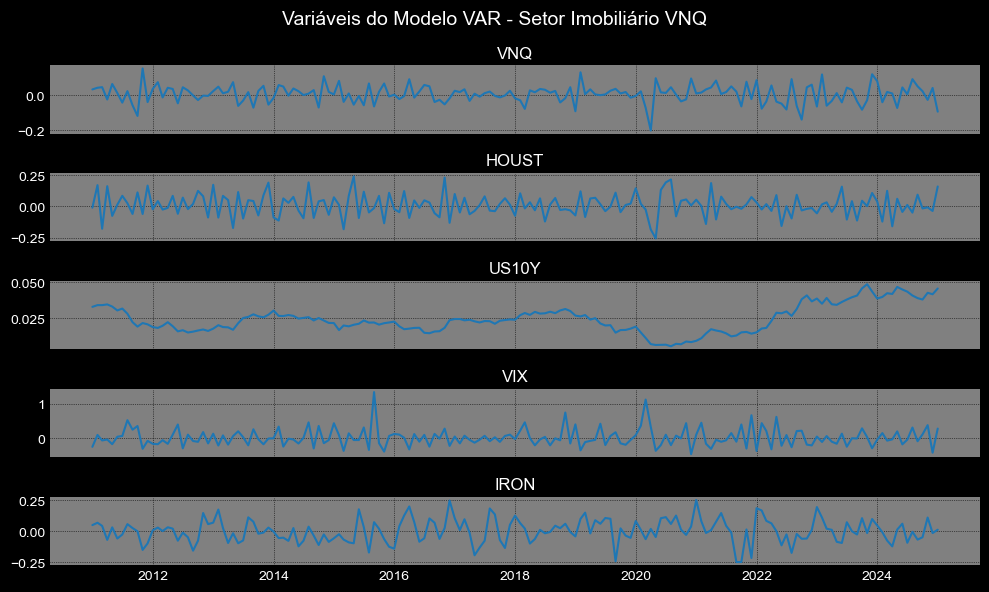

In [125]:
import matplotlib.pyplot as plt

# Criação do gráfico
fig, axes = plt.subplots(5, 1, figsize=(10, 6), sharex=True)

# Iterando pelas colunas do dataframe e plotando cada uma
for i, ax in enumerate(axes):
    ax.plot(df_model.index, df_model.iloc[:, i])
    ax.set_title(f'{df_model.iloc[:, i].name}', fontsize=12)
    ax.grid(True)

# Ajustando o espaçamento entre os subgráficos
plt.subplots_adjust(hspace=0.4)

# Título principal do gráfico
plt.suptitle(f'Variáveis do Modelo VAR - Setor Imobiliário {TICKER}', fontsize=14,color='white')

# Exibindo o gráfico
plt.tight_layout(rect=[0, 0.0, 1, 1])
plt.show()



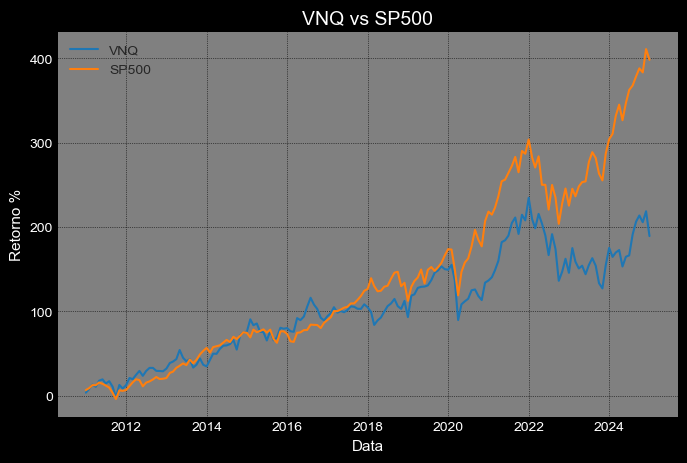

In [126]:
plt.figure(figsize=(8,5))
plt.plot(df_model.index,df_model[[TICKER,'SP500']].add(1).cumprod().sub(1)*100,label=[TICKER,'SP500'])
plt.legend()
plt.grid()
plt.title('VNQ vs SP500',size=14)
plt.ylabel('Retorno %',size=11)
plt.xlabel('Data',size=11)
plt.show()


In [188]:
from sklearn.model_selection import train_test_split
nobs = 12
df_train, df_test = df_model[0:-nobs], df_model[-nobs:]
len(df_test)

12

In [189]:
from statsmodels.tsa.stattools import adfuller
adf_results = [adfuller(df_train[column]) for column in df_train.columns]
adf_results_df = pd.DataFrame(adf_results, columns=['ADF Statistic', 'p-value', 'usedlag', 'nobs', 'critical values', 'icbest'], index=df_train.columns)
print("\nTeste de Dickey-Fuller aumentado:\n")
adf_results_df['ADF Statistic'] = np.round(adf_results_df['ADF Statistic'],2)
adf_results_df['Is_Stationary'] = ['True' if x <= 0.05 else 'False' for x in adf_results_df['p-value']]
adf_results_df['p-value'] = np.round(adf_results_df['p-value'],4)
adf_results_df[['ADF Statistic', 'p-value', 'Is_Stationary' ]]


Teste de Dickey-Fuller aumentado:



,ADF Statistic,p-value,Is_Stationary
VNQ,-10.71,0.0000,True
HOUST,-6.66,0.0000,True
US10Y,-1.45,0.5593,False
VIX,-15.76,0.0000,True
IRON,-7.37,0.0000,True
SP500,-10.71,0.0000,True


In [190]:
df_train['US10Y'] = df_train['US10Y'].diff(1)
df_test['US10Y'] = df_test['US10Y'].diff(1)
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)
from statsmodels.tsa.stattools import adfuller
adf_results = [adfuller(df_train[column]) for column in df_train.columns]
adf_results_df = pd.DataFrame(adf_results, columns=['ADF Statistic', 'p-value', 'usedlag', 'nobs', 'critical values', 'icbest'], index=df_train.columns)
print("\nTeste de Dickey-Fuller aumentado:\n")
adf_results_df['ADF Statistic'] = np.round(adf_results_df['ADF Statistic'],2)
adf_results_df['Is_Stationary'] = ['True' if x <= 0.05 else 'False' for x in adf_results_df['p-value']]
adf_results_df['p-value'] = np.round(adf_results_df['p-value'],4)
adf_results_df[['ADF Statistic', 'p-value', 'Is_Stationary' ]]


Teste de Dickey-Fuller aumentado:



,ADF Statistic,p-value,Is_Stationary
VNQ,-10.75,0.0,True
HOUST,-6.68,0.0,True
US10Y,-10.80,0.0,True
VIX,-15.65,0.0,True
IRON,-7.37,0.0,True
SP500,-10.72,0.0,True


In [191]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.9':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print(f'Name   ::  Test Stat > C({(1-alpha)*100}%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

print('Teste de Cointegração de Johansen')
cointegration_test(df_train,alpha=0.05)

Teste de Cointegração de Johansen
Name   ::  Test Stat > C(95.0%)    =>   Signif  
 ----------------------------------------
VNQ    ::  178.54    > 83.9383   =>   True
HOUST  ::  125.62    > 60.0627   =>   True
US10Y  ::  79.49     > 40.1749   =>   True
VIX    ::  43.4      > 24.2761   =>   True
IRON   ::  20.84     > 12.3212   =>   True
SP500  ::  6.03      > 4.1296    =>   True


In [192]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag=12

test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):  

  """Check Granger Causality of all possible combinations of the Time series.

  The rows are the response variable, columns are predictors. The values in the table

  are the P-Values. P-Values lesser than the significance level (0.05), implies

  the Null Hypothesis that the coefficients of the corresponding past values is

  zero, that is, the X does not cause Y can be rejected.

  

  data   : pandas dataframe containing the time series variables

  variables : list containing names of the time series variables.

  """

  df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

  for c in df.columns:

    for r in df.index:

      test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)

      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]

      if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')

      min_p_value = np.min(p_values)

      df.loc[r, c] = min_p_value

  df.columns = [var + '_x' for var in variables]

  df.index = [var + '_y' for var in variables]

  return df

  

print("Teste de Causalidade de Granger")

grangers_causation_matrix(df_model, variables = df_model.columns)

Teste de Causalidade de Granger


,VNQ_x,HOUST_x,US10Y_x,VIX_x,IRON_x,SP500_x
VNQ_y,1.0000,0.0993,0.1040,0.0389,0.2019,0.1274
HOUST_y,0.0330,1.0000,0.0024,0.0000,0.3755,0.0001
US10Y_y,0.4862,0.3622,1.0000,0.0343,0.1419,0.1661
VIX_y,0.2982,0.0051,0.6594,1.0000,0.4332,0.0100
IRON_y,0.0382,0.0092,0.0292,0.5157,1.0000,0.1044
SP500_y,0.1540,0.0821,0.2089,0.0564,0.0155,1.0000


In [215]:
from statsmodels.tsa.vector_ar.var_model import VAR


model_VAR = VAR(df_train)


model_VAR_fitted = model_VAR.fit(maxlags=len(df_test))  
resids_var = model_VAR_fitted.resid
print(model_VAR_fitted.k_ar)
display(model_VAR_fitted.summary())

11


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 19, Jan, 2025
Time:                     20:33:11
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -29.3239
Nobs:                     145.000    HQIC:                  -34.2232
Log likelihood:           1891.83    FPE:                7.55175e-17
AIC:                     -37.5766    Det(Omega_mle):     7.73109e-18
--------------------------------------------------------------------
Results for equation VNQ
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            -0.002533         0.010669           -0.237           0.812
L1.VNQ           -0.267016         0.175772           -1.519           0.129
L1.HOUST          0.106451         0.072204            1.474           0.140
L

In [222]:
print('Equações para as Variáveis')
model_VAR_fitted.params

Equações para as Variáveis


,VNQ,HOUST,US10Y,VIX,IRON,SP500
const,-0.002533,0.008557,0.000144,-0.023548,0.019027,0.014980
L1.VNQ,-0.267016,0.156516,0.008843,0.234363,-0.162443,-0.078720
L1.HOUST,0.106451,-0.563275,0.000425,-0.268855,0.111358,0.088321
L1.US10Y,-3.250179,1.516186,0.259826,4.501965,-4.722085,-2.134709
L1.VIX,-0.038837,-0.082941,-0.003819,-0.076552,0.089349,-0.044136
...,...,...,...,...,...,...
L11.HOUST,-0.091812,0.004813,-0.000969,0.276104,0.012794,-0.013001
L11.US10Y,0.010811,0.442335,-0.092280,-8.611986,2.445033,0.830081
L11.VIX,0.018955,0.057189,0.001050,-0.019300,0.018780,0.002969
L11.IRON,0.079479,-0.174745,-0.003765,-0.126814,0.012054,0.063807


In [216]:
from statsmodels.stats.diagnostic import acorr_ljungbox


ljung_box_results = pd.DataFrame()
for column in resids_var.columns:
    ljung_box_results[column] = acorr_ljungbox(resids_var[column], lags=[10], return_df=True).T
print("\nTeste de Ljung-Box:\n")
ljung_box_results.style.format('{:.5f}')


Teste de Ljung-Box:



,VNQ,HOUST,US10Y,VIX,IRON,SP500
lb_stat,7.50718,6.73312,4.03442,5.65012,2.19906,3.95068
lb_pvalue,0.67685,0.75038,0.94578,0.84375,0.99457,0.94954


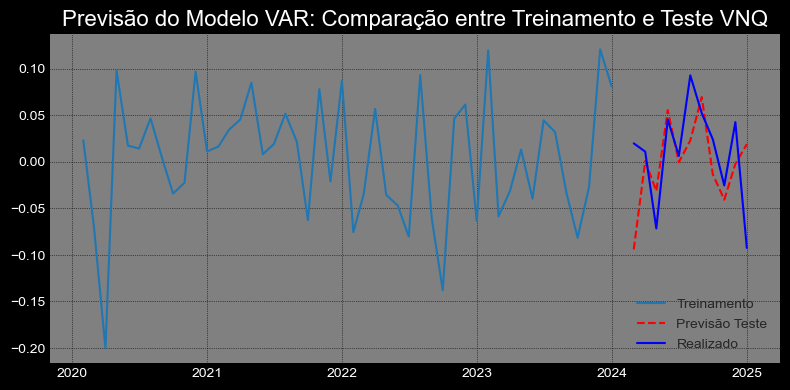

In [217]:
import matplotlib.pyplot as plt

# Fazendo previsões para o conjunto de treino (df_train)
train_forecast = model_VAR_fitted.fittedvalues

# Fazendo previsões para o conjunto de teste (df_test)
forecast_steps = len(df_test)  # Número de passos para o teste
test_forecast = model_VAR_fitted.forecast(df_train.values[-model_VAR_fitted.k_ar:], steps=forecast_steps)
test_forecast = pd.DataFrame(test_forecast,columns=df_train.columns)
# Criando um gráfico para visualizar as previsões
plt.figure(figsize=(8, 4))

# Plotando as variáveis para o treino

plt.subplot()
plt.plot(df_train.tail(48).index, df_train.tail(48)[TICKER], label='Treinamento', color='tab:blue')
plt.plot(df_test.index, test_forecast[TICKER], label='Previsão Teste', color='red', linestyle='dashed')
plt.plot(df_test.index,df_test[TICKER],label='Realizado',color='blue')
plt.title(f'Previsão para {TICKER}')
plt.legend()
plt.grid()

plt.tight_layout()
plt.title(f'Previsão do Modelo VAR: Comparação entre Treinamento e Teste {TICKER}', fontsize=16)
plt.show()


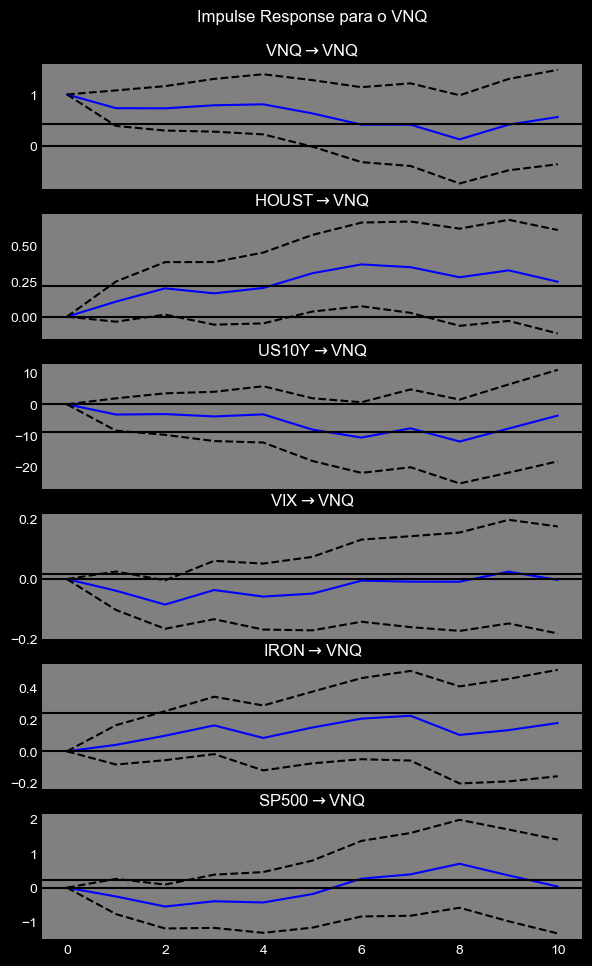

In [262]:
# Gerando o impulso de resposta (Impulse Response) para o VNQ
from statsmodels.tsa.vector_ar.irf import IRAnalysis

irf = model_VAR_fitted.irf(10) 


irf.plot_cum_effects(response=TICKER,figsize=(6,10),plot_params=True)
plt.suptitle(f'Impulse Response para o {TICKER}',color='white')
plt.show()

